## Description:
Extracts an HDF5 file of the specified temperature isocontour(in progress variable form) of the imported nek output.

In [1]:
from __future__ import annotations

from pathlib import Path
import os
os.chdir("../../..")

from typing import Optional, List

import yaml
import numpy as np
import pandas as pd
from mpi4py import MPI

from flamekit.datasets import SEMDataset
from flamekit.io_fronts import Case, folder, front_path
from flamekit.io_fields import make_case_with_base_dir


# -----------------------------
# MPI init
# -----------------------------
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

if rank == 0:
    print(f"MPI world size: {size}")
    if size == 1:
        print("MPI world size is 1. Launch with: mpirun -n N python ... to use multiple processes.")



MPI world size: 1
MPI world size is 1. Launch with: mpirun -n N python ... to use multiple processes.


### Read config file and define helper functions

In [2]:
# -----------------------------
# MPI init
# -----------------------------
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

if rank == 0:
    print(f"MPI world size: {size}")
    if size == 1:
        print("MPI world size is 1. Launch with: mpirun -n N python ... to use multiple processes.")



PROJECT_ROOT = Path.cwd().resolve()


CONFIG_PATH = PROJECT_ROOT / "notebooks" / "preprocessing" / "extract_isocontours" / "extract_isocontours.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

DATA_BASE_DIR = PROJECT_ROOT / Path(CFG["DATA_BASE_DIR"])
ISOCONTOUR_BASE_DIR = PROJECT_ROOT / Path(CFG["ISOCONTOUR_BASE_DIR"])

POST = bool(CFG["POST"])
FILE_NAME = "po_postPremix" if POST else "premix"

PHI = float(CFG["PHI"])
LAT_SIZE = int(CFG["LAT_SIZE"])

TIME_STEP = int(CFG["TIME_STEP"])
MULTI_TIME_STEP = bool(CFG["MULTI_TIME_STEP"])
TIME_STEP_START = int(CFG["TIME_STEP_START"])
TIME_STEP_END = int(CFG["TIME_STEP_END"])

PROGRESS_LEVELS = [float(x) for x in CFG["PROGRESS_LEVELS"]]

SCALARS = list(CFG["SCALARS"])
COMP_T_GRAD = bool(CFG["COMP_T_GRAD"])
COMP_CURV_GRAD = bool(CFG["COMP_CURV_GRAD"])
COMP_LOCAL_VEL_JACOBIAN = bool(CFG["COMP_LOCAL_VEL_JACOBIAN"])
COMP_REACTION_RATES = bool(CFG["COMP_REACTION_RATES"])

T_REF = float(CFG["T_REF"])
P_REF = float(CFG["P_REF"])
CANTERA_YAML = PROJECT_ROOT / Path(CFG["CANTERA_YAML"])
CANTERA_INPUTS = [str(CANTERA_YAML), None, T_REF, P_REF]  # [cantera_file, species_list, t_ref, p_ref]


# -----------------------------
# Core routine
# -----------------------------
def process_isocontours(
    *,
    time_steps: List[int],
    comm: Optional[MPI.Comm] = None,
) -> None:
    """
    MPI-parallel isocontour extraction that writes **one** file per (timestep, iso),
    while using all MPI ranks for reading + derived-field computation + contouring.

    Each rank extracts its local contour segment; rank 0 gathers and concatenates.
    """

    # Build a reference case for locating data folder (assumed invariant over time)
    ts0 = int(time_steps[0])
    case0 = Case(base_dir=ISOCONTOUR_BASE_DIR, phi=PHI, lat_size=LAT_SIZE, time_step=ts0, post=POST)
    data_case0 = make_case_with_base_dir(case0, DATA_BASE_DIR)
    folder_name = folder(data_case0)

    # Dataset once (mesh + coef once)
    ds = SEMDataset(
        folder_name=str(folder_name),
        file_name=FILE_NAME,
        time_step=ts0,
        comm=comm,
        scalar_names=SCALARS,
    )

    # Build cached PyVista connectivity once per rank (local partition)
    ds.build_pyvista_grid_2d()

    for ts in map(int, time_steps):
        # Output structure per timestep
        case = Case(base_dir=ISOCONTOUR_BASE_DIR, phi=PHI, lat_size=LAT_SIZE, time_step=ts, post=POST)
        out_case = make_case_with_base_dir(case, ISOCONTOUR_BASE_DIR)
        save_dir = folder(out_case)

        if rank == 0:
            save_dir.mkdir(parents=True, exist_ok=True)
        comm.Barrier()

        # Reload fields for this timestep (MPI-distributed by pySEMTools)
        ds.reload_timestep(ts)

        # Build the set of arrays that should live on the grid for contour interpolation
        point_data = ds.build_point_data_dict(
            cantera_inputs=CANTERA_INPUTS,
            phi=PHI,
            compute_progress_var=True,
            compute_T_grad=COMP_T_GRAD,
            compute_curv_grad=COMP_CURV_GRAD,
            compute_local_vel_jacobian=COMP_LOCAL_VEL_JACOBIAN,
            compute_reaction_rates=COMP_REACTION_RATES,
        )

        # Attach arrays to cached grid for this timestep
        ds.update_pyvista_point_data(**point_data)

        expected_cols = ["x", "y", "z"] + sorted(point_data.keys())

        for iso in PROGRESS_LEVELS:
            iso = float(iso)


            front_local = ds.extract_flame_front(
                c_level=iso,
                scalar_name="progress_var",
                include_point_data=True,
            )

            # Ensure consistent columns (PyVista may omit arrays in edge cases)
            for c in expected_cols:
                if c not in front_local.columns:
                    front_local[c] = np.nan
            front_local = front_local[expected_cols]

            # Gather all local pieces -> rank 0 writes one file
            fronts = comm.gather(front_local, root=0)

            if rank == 0:
                front_global = pd.concat(fronts, ignore_index=True) if fronts else pd.DataFrame(columns=expected_cols)
                if front_global.empty:
                    front_global = pd.DataFrame(columns=expected_cols)

                out_path = front_path(out_case, iso)
                front_global.to_hdf(out_path, key="front", mode="w", format="fixed", index=False)

        comm.Barrier()

    if rank == 0:
        print(f"[rank0] Done. Processed {len(time_steps)} timesteps with MPI size={size}.")

MPI world size: 1
MPI world size is 1. Launch with: mpirun -n N python ... to use multiple processes.


### Run

In [3]:
if MULTI_TIME_STEP:
    time_steps = list(range(TIME_STEP_START, TIME_STEP_END + 1))
else:
    time_steps = [TIME_STEP]

process_isocontours(time_steps=time_steps, comm=comm)

2026-01-24 21:43:41,094  pynekread             INFO      Reading file: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/nek/phi0.40/h400x200_ref/po_postPremix0.f00001
2026-01-24 21:43:41,476  Mesh                  INFO      Mesh object initialized from coordinates with type: float64 - Elapsed time: 0.20316458299999998s
2026-01-24 21:43:41,477  pynekread             INFO      File successfully read - Elapsed time: 0.382545236s
2026-01-24 21:43:41,478  Coef                  INFO      Initializing Coef object
2026-01-24 21:43:41,478  Coef                  INFO      Getting derivative matrices
2026-01-24 21:43:41,479  Coef                  INFO      Calculating the components of the jacobian
2026-01-24 21:43:41,839  Coef                  INFO      Calculating the jacobian determinant and inverse of the jacobian matrix
2026-01-24 21:43:41,951  Coef                  INFO      Calculating the mass matrix
2026-01-24 21:43:41,963  Coef                  INFO      Coef object 

### Plotting

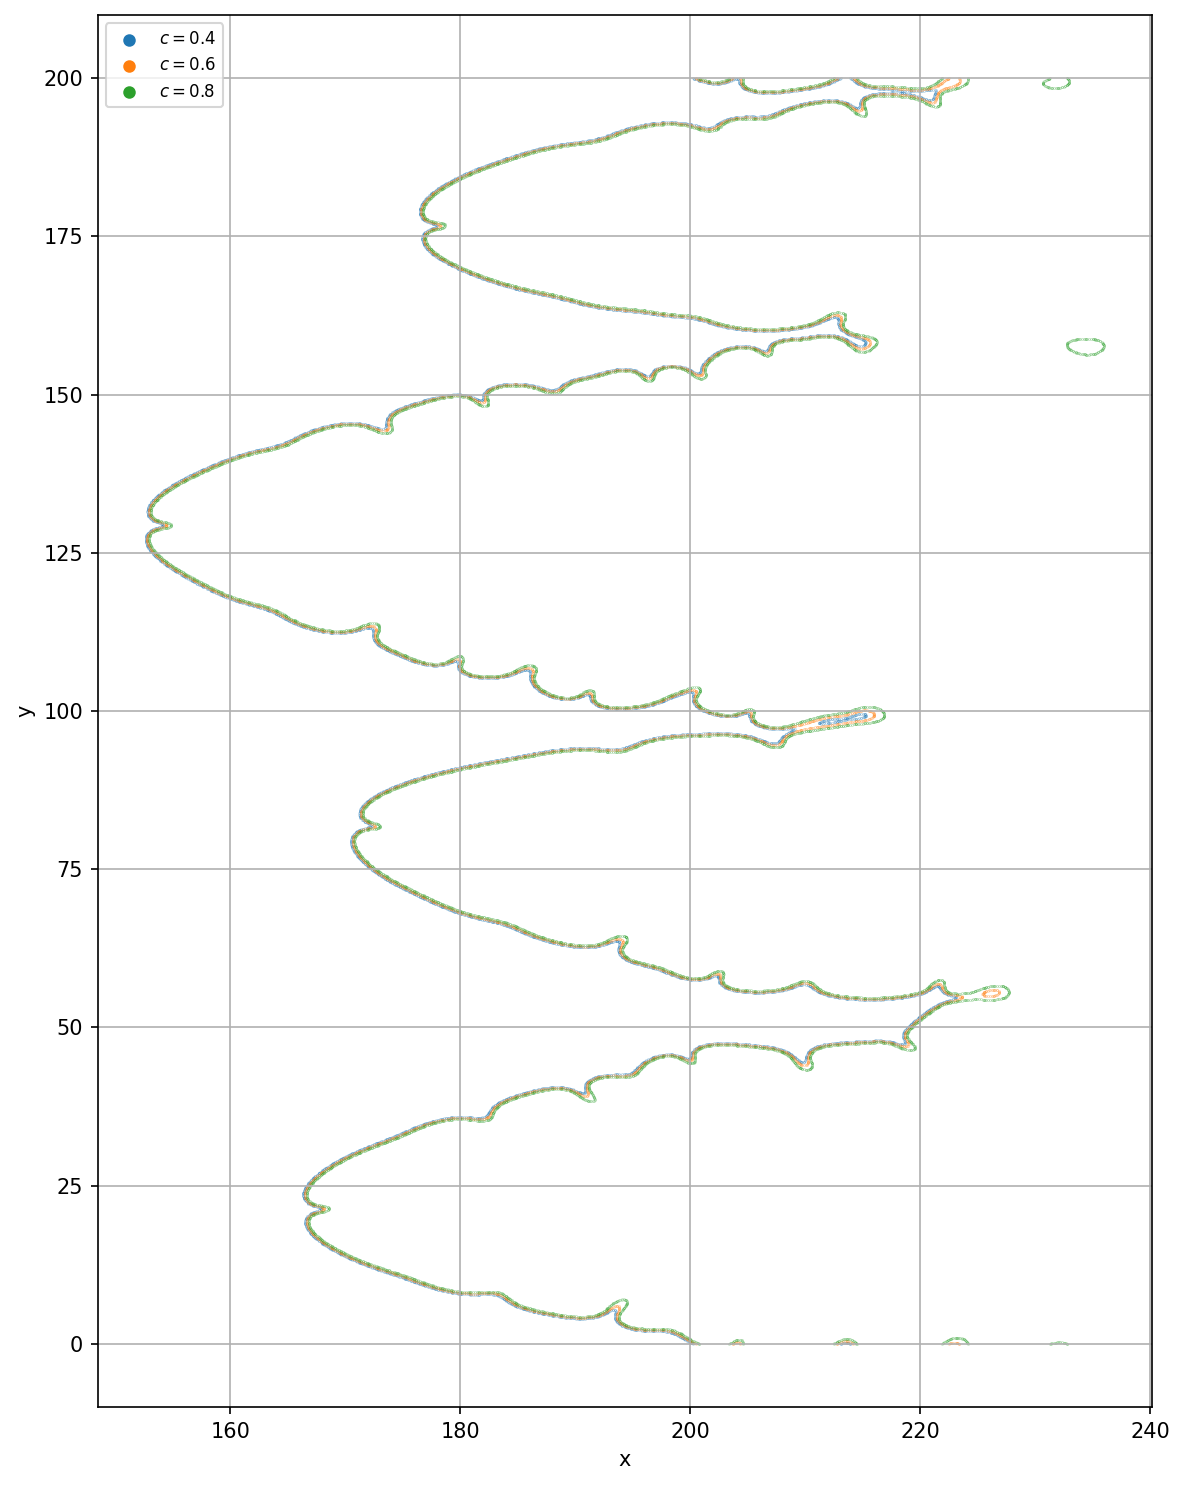